In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
all_gb_df = pd.read_csv('../../data/derived/plays/all_gb_df.csv').drop(columns='Unnamed: 0')
ball_pos_df = pd.read_csv('../../data/combined/ball_pos.csv').drop(columns='Unnamed: 0')
inf_gb_throw_df = pd.read_csv('../../data/derived/plays/inf_gb_with_throw_1b_df.csv').drop(columns='Unnamed: 0')
game_events_df = pd.read_csv('../../data/combined/game_events.csv').drop(columns='Unnamed: 0')
game_info_df = pd.read_csv('../../data/combined/game_info.csv').drop(columns='Unnamed: 0')
any_inf_gb_df = pd.read_csv('../../data/derived/plays/any_inf_gb_df.csv').drop(columns='Unnamed: 0')
player_pos_df = pd.read_csv('../../data/combined/player_pos.csv').drop(columns='Unnamed: 0')

In [3]:
all_gb_df = all_gb_df[['game_str', 'play_id', 'timestamp']]
all_gb_df = ball_pos_df.merge(all_gb_df, how='inner', on=['game_str', 'play_id'], suffixes=['', '_contact'])

# grab the first row that is >= 100 milliseconds after contact
def skip_time(group):
    after_contact_rows = group.loc[group['timestamp'] >= group['timestamp_contact']]
    if after_contact_rows.empty:
        return pd.DataFrame()
    
    skip_time_row = after_contact_rows.loc[after_contact_rows['timestamp'] >= after_contact_rows['timestamp_contact'] + 250]
    if skip_time_row.empty:
        return pd.DataFrame()

    rows = pd.DataFrame([after_contact_rows.iloc[1], after_contact_rows.iloc[2], skip_time_row.iloc[0]])
    # print(rows)
    return rows

# Apply the custom function to each group and continuously concatenate the results
grouped = all_gb_df.groupby(['game_str', 'play_id'])
gb_prop_df = pd.DataFrame(columns=['game_str', 'play_id', 'timestamp', 'ball_position_x', 
                                       'ball_position_y', 'ball_position_z'])

n_groups = grouped.ngroups
i = 0
for name, group in grouped:
    # print(f'{i} / {n_groups}')
    result = skip_time(group)
    if not result.empty:
        gb_prop_df = pd.concat([gb_prop_df, result], ignore_index=True)
    i += 1

# Reset the index of concatenated_df
gb_prop_df.reset_index(drop=True, inplace=True)

# Calculate exit velo for each ground ball
def calculate_exit_velo(group):
    y_diff = group['ball_position_y'].iloc[1] - group['ball_position_y'].iloc[0]
    x_diff = group['ball_position_x'].iloc[1] - group['ball_position_x'].iloc[0]
    time_diff = group['timestamp'].iloc[1] - group['timestamp'].iloc[0]
    group['exit_velo'] = np.sqrt(y_diff ** 2 + x_diff ** 2) / time_diff
    return group

gb_prop_df = gb_prop_df.groupby(['game_str', 'play_id'], group_keys=False).apply(calculate_exit_velo)
gb_prop_df['exit_velo'] = gb_prop_df['exit_velo'] * 0.681818 * 1000

# Calculate spray angle by finding the angle between the ball vector and the vector from home to second base (0, 1)
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    angle_rad = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    angle_deg = np.rad2deg(angle_rad)
    
    # Adjust the angle to the range of -45 to 45 degrees
    if v1[0] > v2[0]:
        angle_deg = -angle_deg
    
    return angle_deg

# Calculate spray angle for each group
def calculate_spray_angle(group):
    ball_vector = np.array([group['ball_position_x'].iloc[2], group['ball_position_y'].iloc[2]])
    home_to_second_base = np.array([0.0, 1.0])
    spray_angle = angle_between(ball_vector, home_to_second_base)
    group['spray_angle'] = spray_angle
    return group

gb_prop_df = gb_prop_df.groupby(['game_str', 'play_id'], group_keys=False).apply(calculate_spray_angle)

# Display the DataFrame with the calculated 'spray_angle' column
gb_prop_df.head()

,game_str,play_id,timestamp,ball_position_x,ball_position_y,ball_position_z,timestamp_contact,exit_velo,spray_angle
0,1900_03_TeamKJ_TeamB,8,178373.0,0.126178,1.267806,2.585058,178340.0,67.661669,20.135095
1,1900_03_TeamKJ_TeamB,8,178406.0,-0.216722,4.524630,0.754101,178340.0,67.661669,20.135095
2,1900_03_TeamKJ_TeamB,8,178604.0,-3.202650,8.735070,2.763855,178340.0,67.661669,20.135095
3,1900_03_TeamKJ_TeamB,137,5627451.0,0.883500,4.427220,2.528307,5627418.0,44.655318,-30.094554
4,1900_03_TeamKJ_TeamB,137,5627484.0,2.141568,6.184650,3.213060,5627418.0,44.655318,-30.094554


In [4]:
gb_prop_df['fielded_by_inf'] = gb_prop_df.apply(lambda row: any((any_inf_gb_df['game_str'] == row['game_str']) &
                                                                (any_inf_gb_df['play_id'] == row['play_id'])), axis=1)

gb_prop_df = gb_prop_df.drop(columns=['ball_position_x', 'ball_position_y', 'ball_position_z'])
print(f'Average exit velocity on ground balls based on whether they were fielded by an infielder: {gb_prop_df.groupby("fielded_by_inf")["exit_velo"].mean()}')
gb_prop_df.head()

Average exit velocity on ground balls based on whether they were fielded by an infielder: fielded_by_inf
False    78.198909
True     68.483119
Name: exit_velo, dtype: float64


,game_str,play_id,timestamp,timestamp_contact,exit_velo,spray_angle,fielded_by_inf
0,1900_03_TeamKJ_TeamB,8,178373.0,178340.0,67.661669,20.135095,True
1,1900_03_TeamKJ_TeamB,8,178406.0,178340.0,67.661669,20.135095,True
2,1900_03_TeamKJ_TeamB,8,178604.0,178340.0,67.661669,20.135095,True
3,1900_03_TeamKJ_TeamB,137,5627451.0,5627418.0,44.655318,-30.094554,True
4,1900_03_TeamKJ_TeamB,137,5627484.0,5627418.0,44.655318,-30.094554,True


In [5]:
# Grab all unique IDs who fielded a ball and threw to first base
fielder_ids = inf_gb_throw_df.merge(game_info_df, how='inner', on=['game_str', 'play_per_game'])
pos_dict = {1:'pitcher', 2:'catcher', 3:'first_base', 4:'second_base', 5:'third_base', 6:'shortstop'}
fielder_ids['player_id'] = fielder_ids.apply(lambda row: row[pos_dict[row['player_position']]], axis=1)
fielder_ids = fielder_ids['player_id'].unique()
print(f'Num unique fielders: {len(fielder_ids)}')

# Grab all times those unique IDs hit a ball into play to record their max speed
hit_into_play_df = game_events_df.loc[game_events_df['event_code'] == 4, ['game_str', 'at_bat', 'play_id']]
hit_into_play_df = hit_into_play_df.merge(game_info_df, how='inner', on=['game_str', 'at_bat'])

fielder_contact = hit_into_play_df.loc[hit_into_play_df['batter'].isin(fielder_ids)]
fielder_contact = fielder_contact[['game_str', 'play_id', 'batter']]
print(f'Num fielders who made contact: {fielder_contact["batter"].nunique()}')

# Grab the positions of players on plays where a ID of interest made contact
fielder_contact = fielder_contact.merge(player_pos_df, how='inner', on=['game_str', 'play_id'])
# Filter for batter's positions only
fielder_contact = fielder_contact.loc[fielder_contact['player_position'] == 10]

fielder_contact.head()

Num unique fielders: 155
Num fielders who made contact: 155


,game_str,play_id,batter,timestamp,player_position,field_x,field_y
1895,1903_01_TeamNE_TeamA2,12,9762,226703.0,10,3.2751,-0.1002
1896,1903_01_TeamNE_TeamA2,12,9762,226736.0,10,3.2676,-0.0813
1897,1903_01_TeamNE_TeamA2,12,9762,226769.0,10,3.2571,-0.0639
1898,1903_01_TeamNE_TeamA2,12,9762,226802.0,10,3.2448,-0.0480
1899,1903_01_TeamNE_TeamA2,12,9762,226835.0,10,3.2310,-0.0333


In [16]:
def calculate_best_times(group):
    while i < len(group):
        


best_sub_90_times_df = pd.DataFrame(index=fielder_contact['batter'].unique(), columns=np.arange(1, 91))

fielder_contact.groupby(['game_str', 'play_id', 'batter']).apply(calculate_best_times)

best_sub_90_times_df.head()

(155, 90)

In [10]:
def calculate_max_speed_on_play(group):
    max_speed = 0.0
    pos_1 = np.array([group['field_x'].iloc[0], group['field_y'].iloc[0]])
    time_1 = group['timestamp'].iloc[0]

    i = 1
    while i < len(group):
        time_2 = group['timestamp'].iloc[i]
        delta_time = time_2 - time_1
        if delta_time < 100:
            i += 1
        else:
            pos_2 = np.array([group['field_x'].iloc[i], group['field_y'].iloc[i]])
            speed = np.linalg.norm(pos_2 - pos_1) / delta_time
            if speed > max_speed:
                max_speed = speed
            pos_1 = pos_2
            time_1 = time_2
            i += 1
    return pd.Series({'max_speed': max_speed})

# Calculate the max speed for each play and player
fielder_max_speed = fielder_contact.groupby(['game_str', 'play_id', 'batter']).apply(calculate_max_speed_on_play).reset_index()
fielder_max_speed = fielder_max_speed.groupby('batter')['max_speed'].max()
fielder_max_speed_df = pd.DataFrame(fielder_max_speed).reset_index()

fielder_max_speed_df['max_speed'] = fielder_max_speed_df['max_speed'] * 0.681818 * 1000
print(f'Number of fielders with a max speed: {fielder_max_speed_df["batter"].nunique()}')
print(fielder_max_speed_df['max_speed'].describe())

# Display the calculated max speeds
fielder_max_speed_df.head()

Number of fielders with a max speed: 155
count    155.000000
mean      29.626633
std       26.330039
min       16.757439
25%       20.150796
50%       23.247031
75%       26.946130
max      156.333264
Name: max_speed, dtype: float64


,batter,max_speed
0,1080,24.839231
1,1119,27.418296
2,1144,24.776584
3,1181,27.153289
4,1258,45.558275


count     155.000000
mean      196.058021
std       870.983895
min        16.762187
25%        25.434555
50%        32.925820
75%        37.560972
max      4949.045157
Name: max_speed, dtype: float64


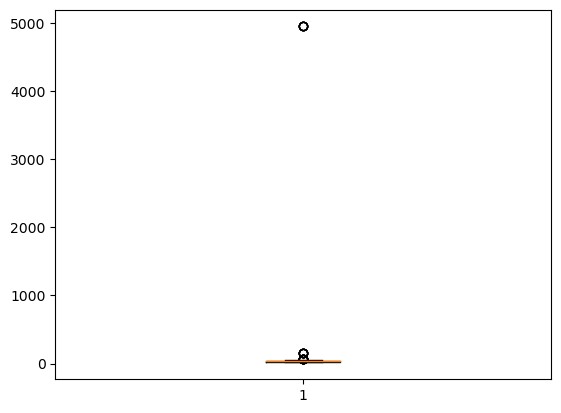

count    136.000000
mean      30.574808
std        7.646587
min       16.762187
25%       22.710933
50%       31.892476
75%       36.172639
max       51.181919
Name: max_speed, dtype: float64


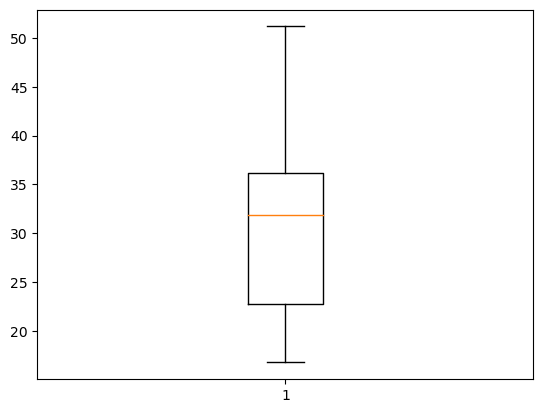

,batter,max_speed
0,1080,33.857572
1,1119,36.712626
2,1144,33.002931
3,1181,36.116729
4,1258,45.560320


In [7]:
print(fielder_max_speed_df['max_speed'].describe())

# Create a box and whisker plot of the max speeds, then use the 1.5 IQR to filter outliers. Describe the data again, make another plot.
plt.boxplot(fielder_max_speed_df['max_speed'])
plt.show()

# Filter outliers
q1 = fielder_max_speed_df['max_speed'].quantile(0.25)
q3 = fielder_max_speed_df['max_speed'].quantile(0.75)
iqr = q3 - q1

fielder_max_speed_df = fielder_max_speed_df.loc[(fielder_max_speed_df['max_speed'] >= q1 - 1.5 * iqr) &
                                                (fielder_max_speed_df['max_speed'] <= q3 + 1.5 * iqr)]

print(fielder_max_speed_df['max_speed'].describe())

plt.boxplot(fielder_max_speed_df['max_speed'])
plt.show()

fielder_max_speed_df.head()